In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import font_manager

In [2]:
# glm = ["ridge", "lasso", "elastic"]
# normalize = {True: "normed", False: "nonnormed"}
# square = {True: "squared", False: "nosquared"}
# ranking = {True: "rank", False: "norank"}

# create the mapping of variants to argument mappings
# lfi_methods =[]
# for g in glm:
#     for n in normalize:
#         for s in square:
#             if (not n) and (s):
#                 continue
#             for r in ranking:
#                 # create the name the variant will be stored under
#                 variant_name = f"{g}_{normalize[n]}_{square[s]}_{ranking[r]}"
#                 lfi_methods.append(variant_name)
# lfi_methods.append("shap")
# lfi_methods.append("lime")
# lfi_methods.append("lmdi_baseline")
lfi_methods = ["elastic_nonnormed_nosquared_rank", "lmdi_baseline", "lime", "shap"]

In [3]:
# methods = ['shap', 'signed_normalized_l2_avg', 'signed_normalized_l2_noavg',
#            'signed_nonnormalized_l2_avg', 'signed_nonnormalized_l2_noavg',
#            'nonl2_avg', 'nonl2_noavg', 'l2_ranking', 'nonl2_ranking',
#            'normalized_l2_ranking', 'baseline', 'mdi']
pves = [0.1, 0.4]
rhos = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
rf_mean_results = {}
rf_sd_results = {}
gb_mean_results = {}
gb_sd_results = {}
for method in lfi_methods:
    rf_group_results = {}
    rf_sd_group_results = {}
    rf_sig_mat = np.zeros((len(pves), len(rhos)))
    rf_c_nsig_mat = np.zeros((len(pves), len(rhos)))
    rf_nsig_mat = np.zeros((len(pves), len(rhos)))
    rf_sig_sd = np.zeros((len(pves), len(rhos)))
    rf_c_nsig_sd = np.zeros((len(pves), len(rhos)))
    rf_nsig_sd = np.zeros((len(pves), len(rhos)))
    gb_group_results = {}
    gb_sd_group_results = {}
    gb_sig_mat = np.zeros((len(pves), len(rhos)))
    gb_c_nsig_mat = np.zeros((len(pves), len(rhos)))
    gb_nsig_mat = np.zeros((len(pves), len(rhos)))
    gb_sig_sd = np.zeros((len(pves), len(rhos)))
    gb_c_nsig_sd = np.zeros((len(pves), len(rhos)))
    gb_nsig_sd = np.zeros((len(pves), len(rhos)))
    for pve_idx in range(len(pves)):
        for rho_idx in range(len(rhos)):
            # rankings = np.zeros((250, 100, 50)) # 250 samples, 100 features, 50 seeds
            rf_rankings = np.zeros((250, 100, 50)) # 250 samples, 100 features, 50 seeds
            gb_rankings = np.zeros((250, 100, 50)) # 250 samples, 100 features, 50 seeds
            for seed in range(1, 51):
            # for seed in range(1, 51):
                rf_rankings[:, :, seed-1] = pd.read_csv(f"results/pve{pves[pve_idx]}/rho{rhos[rho_idx]}/seed{seed}/rf/rankings/{method}.csv").to_numpy()
                gb_rankings[:, :, seed-1] = pd.read_csv(f"results/pve{pves[pve_idx]}/rho{rhos[rho_idx]}/seed{seed}/gb/rankings/{method}.csv").to_numpy()
                # print(method)
                # print(seed)
                # print(rankings)
            # print(np.mean(rankings, axis = 0).shape)
            rf_sds = np.std(np.mean(rf_rankings, axis = 0), axis=1)/math.sqrt(rf_rankings.shape[0])
            gb_sds = np.std(np.mean(gb_rankings, axis = 0), axis=1)/math.sqrt(gb_rankings.shape[0])
            # print(sds.shape)
            rf_rankings = np.mean(rf_rankings, axis=2)
            gb_rankings = np.mean(gb_rankings, axis=2)
            # average first six columns in rankings
            # print(method + " rankings")
            # print(rankings)
            rf_sig_mat[pve_idx, rho_idx] = np.mean(rf_rankings[:, :6])
            rf_sig_sd[pve_idx, rho_idx] = np.mean(rf_sds[:6])
            gb_sig_mat[pve_idx, rho_idx] = np.mean(gb_rankings[:, :6])
            gb_sig_sd[pve_idx, rho_idx] = np.mean(gb_sds[:6])
            # average features 7-50 in rankings
            rf_c_nsig_mat[pve_idx, rho_idx] = np.mean(rf_rankings[:, 6:50])
            rf_c_nsig_sd[pve_idx, rho_idx] = np.mean(rf_sds[6:50])
            gb_c_nsig_mat[pve_idx, rho_idx] = np.mean(gb_rankings[:, 6:50])
            gb_c_nsig_sd[pve_idx, rho_idx] = np.mean(gb_sds[6:50])
            # average features 51-100 in rankings
            rf_nsig_mat[pve_idx, rho_idx] = np.mean(rf_rankings[:, 50:])
            rf_nsig_sd[pve_idx, rho_idx] = np.mean(rf_sds[50:])
            gb_nsig_mat[pve_idx, rho_idx] = np.mean(gb_rankings[:, 50:])
            gb_nsig_sd[pve_idx, rho_idx] = np.mean(gb_sds[50:])
    rf_group_results['sig'] = rf_sig_mat
    rf_group_results['c_nsig'] = rf_c_nsig_mat
    rf_group_results['nsig'] = rf_nsig_mat
    rf_sd_group_results['sig'] = rf_sig_sd
    rf_sd_group_results['c_nsig'] = rf_c_nsig_sd
    rf_sd_group_results['nsig'] = rf_nsig_sd
    rf_sd_results[method] = rf_sd_group_results
    rf_mean_results[method] = rf_group_results
    gb_group_results['sig'] = gb_sig_mat
    gb_group_results['c_nsig'] = gb_c_nsig_mat
    gb_group_results['nsig'] = gb_nsig_mat
    gb_sd_group_results['sig'] = gb_sig_sd
    gb_sd_group_results['c_nsig'] = gb_c_nsig_sd
    gb_sd_group_results['nsig'] = gb_nsig_sd
    gb_sd_results[method] = gb_sd_group_results
    gb_mean_results[method] = gb_group_results

--------------------------


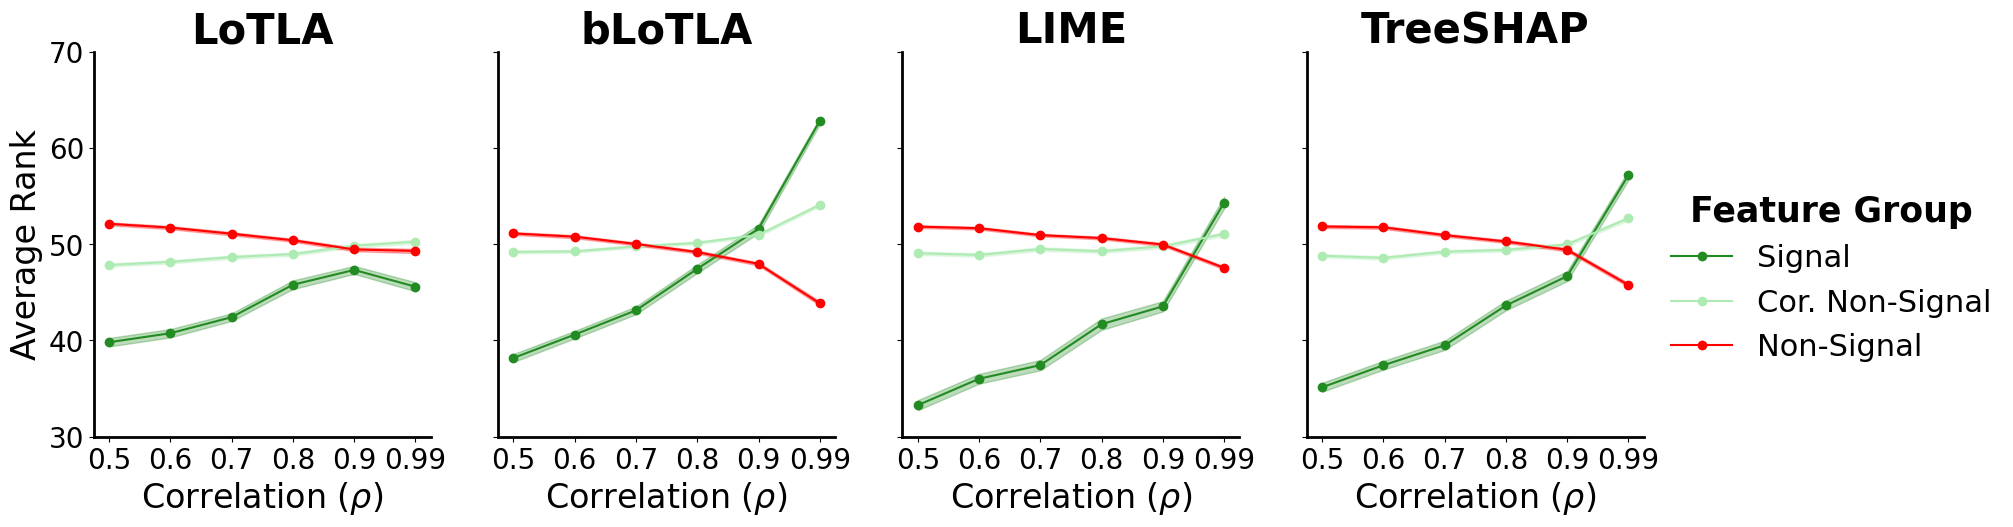

In [24]:
# viz_methods = ['shap', 'nonl2_ranking', 'mdi']
titles = {'shap': 'TreeSHAP', 'lime': 'LIME', 'lmdi_baseline': 'bLoTLA',
          'elastic_nonnormed_nosquared_rank': 'LoTLA'}
rf_plots = []
for pve_idx in range(len([1])): #range(len(pves)): 
    print("--------------------------")
    fig, axs = plt.subplots(1, len(lfi_methods), sharey=True, figsize=(20, 5))
    if pves[pve_idx] == 0.1:
        plt.ylim(30, 70)
    else:
        plt.ylim(10, 70)
    for method_idx in range(len(lfi_methods)):
        # plot results, where each group is a separate line on the plot
        plt.rcParams['axes.labelsize'] = 30
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 12
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        # plt.rcParams['axes.edgecolor'] = 'lightgrey'
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 2.0
        axs[method_idx].plot(rf_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :], marker = "o",
                 label="Signal", color='forestgreen')
        axs[method_idx].fill_between(range(len(rhos)),
                         rf_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] - \
                             rf_sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                             rf_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] + \
                                 rf_sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                                 color='forestgreen', alpha=0.3)
        axs[method_idx].plot(rf_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :], marker = "o",
                 label="Cor. Non-Signal", color='#ADEBB3')
        axs[method_idx].fill_between(range(len(rhos)),
                         rf_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] - \
                             rf_sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                             rf_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] + \
                                 rf_sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                                 color='#ADEBB3', alpha=0.3)
        axs[method_idx].plot(rf_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :], marker = "o",
                 label="Non-Signal", color='red')
        axs[method_idx].fill_between(range(len(rhos)),
                         rf_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] - \
                             rf_sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                             rf_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] + \
                                 rf_sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                                 color = 'red', alpha=0.3)
        # x-label and ticks will be in GB plots, so we remove x-label and ticks
        axs[method_idx].set_xlabel(r'Correlation ($\rho$)', fontsize=24)
        # x-axis ticks should be rho values
        axs[method_idx].set_xticks(range(len(rhos)), rhos)
        # make xaxis label big
        axs[method_idx].tick_params(axis='both', labelsize=20)
        
        # set y-axis ticks at 30, 40, 50, 60, 70
        if pves[pve_idx] == 0.1:
            axs[method_idx].set_yticks([30, 40, 50, 60, 70])
        else:
            axs[method_idx].set_yticks([10, 20, 30, 40, 50, 60, 70])
        # y-axis label should be Average Ranking
        if method_idx == 0:
            axs[method_idx].set_ylabel("Average Rank", fontsize=24)
        axs[method_idx].set_title(titles[lfi_methods[method_idx]], fontsize=30, fontweight='bold')
    title_font_properties = font_manager.FontProperties(weight='bold', size=25)
    plt.legend(title = "Feature Group", loc = "upper left", bbox_to_anchor=(1,0.7),
               fontsize=22, title_fontproperties = title_font_properties, frameon=False)
    # fig.text(0.06, 0.5, "RF Model", ha='center', va='center', rotation=90, fontsize=24, fontstyle='italic', fontweight='bold')
    rf_plots.append(plt.gcf())
    # plt.show()
    plt.savefig("images/bigger/correlation.png", format='png', bbox_inches='tight')
    plt.savefig("images/bigger/correlation.pdf", format='pdf', bbox_inches='tight')

--------------------------


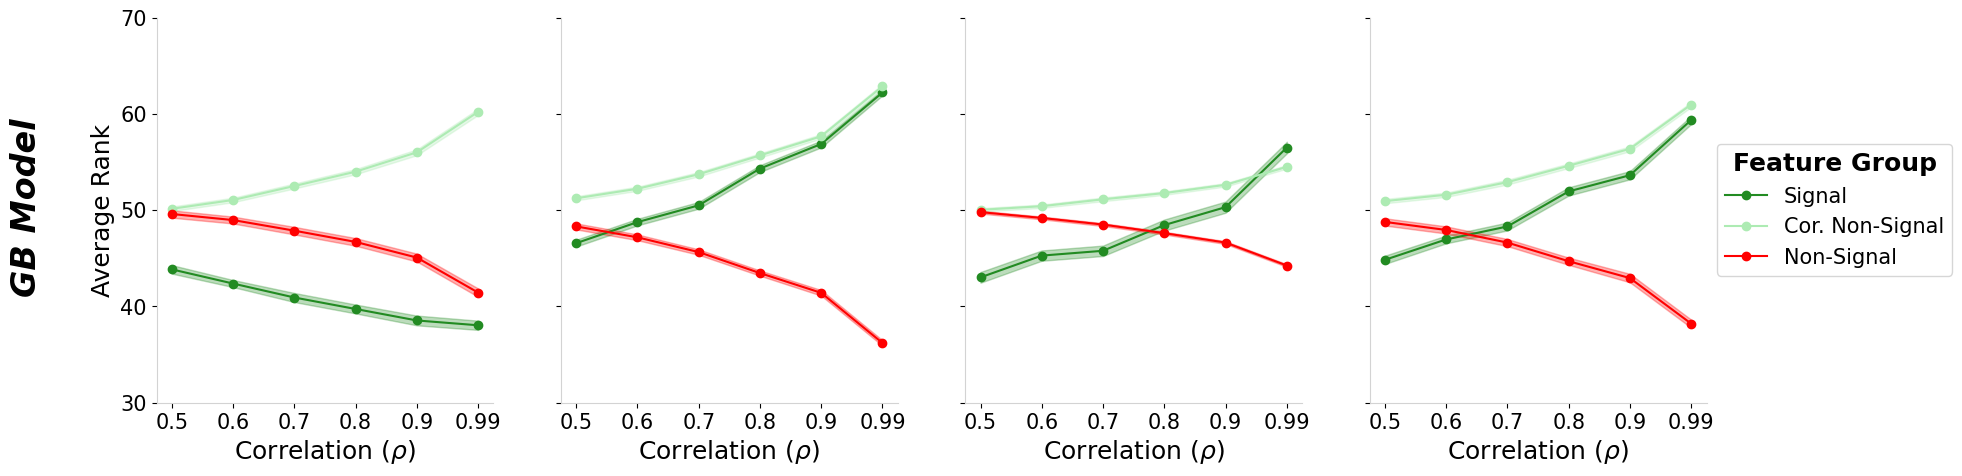

--------------------------


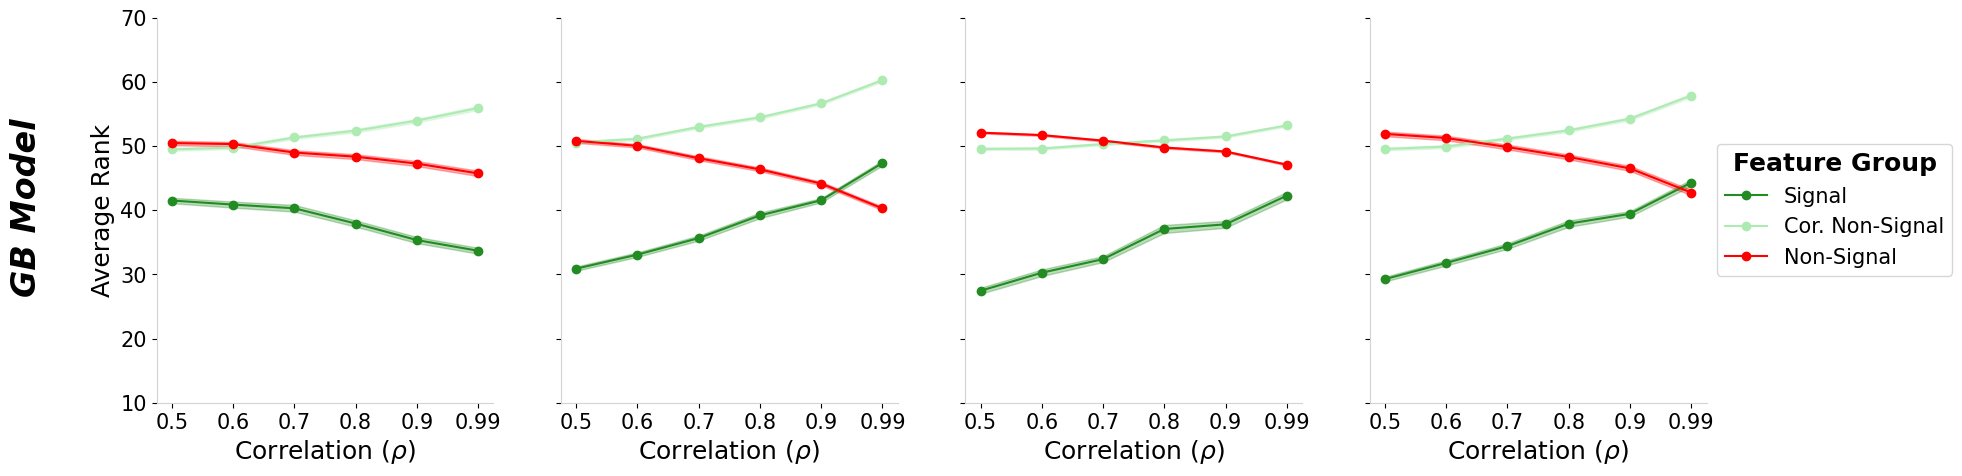

In [12]:
# viz_methods = ['shap', 'nonl2_ranking', 'mdi']
titles = {'shap': 'TreeSHAP', 'lime': 'LIME', 'lmdi_baseline': 'LoTLA',
          'elastic_nonnormed_nosquared_rank': 'LoTLA+'}
gb_plots = []
for pve_idx in range(len(pves)): 
    print("--------------------------")
    fig, axs = plt.subplots(1, len(lfi_methods), sharey=True, figsize=(20, 5))
    if pves[pve_idx] == 0.1:
        plt.ylim(30, 70)
    else:
        plt.ylim(10, 70)
    for method_idx in range(len(lfi_methods)):
        # plot results, where each group is a separate line on the plot
        plt.rcParams['axes.labelsize'] = 30
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 12
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.edgecolor'] = 'lightgrey'
        axs[method_idx].plot(gb_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :], marker = "o",
                 label="Signal", color='forestgreen')
        axs[method_idx].fill_between(range(len(rhos)),
                         gb_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] - \
                             gb_sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                             gb_mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] + \
                                 gb_sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                                 color='forestgreen', alpha=0.3)
        axs[method_idx].plot(gb_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :], marker = "o",
                 label="Cor. Non-Signal", color='#ADEBB3')
        axs[method_idx].fill_between(range(len(rhos)),
                         gb_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] - \
                             gb_sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                             gb_mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] + \
                                 gb_sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                                 color='#ADEBB3', alpha=0.3)
        axs[method_idx].plot(gb_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :], marker = "o",
                 label="Non-Signal", color='red')
        axs[method_idx].fill_between(range(len(rhos)),
                         gb_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] - \
                             gb_sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                             gb_mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] + \
                                 gb_sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                                 color = 'red', alpha=0.3)
        axs[method_idx].set_xlabel(r'Correlation ($\rho$)', fontsize=18)
        # x-axis ticks should be rho values
        axs[method_idx].set_xticks(range(len(rhos)), rhos)
        # make xaxis label big
        axs[method_idx].tick_params(axis='both', labelsize=15)
        # y-axis label should be Average Ranking
        if pves[pve_idx] == 0.1:
            axs[method_idx].set_yticks([30, 40, 50, 60, 70])
        else:
            axs[method_idx].set_yticks([10, 20, 30, 40, 50, 60, 70])
        if method_idx == 0:
            axs[method_idx].set_ylabel("Average Rank", fontsize=18)
        # axs[method_idx].set_title(titles[lfi_methods[method_idx]], fontsize=20, fontweight='bold')
        # set title to blank because it is in RF Model plot
        axs[method_idx].set_title("")
    title_font_properties = font_manager.FontProperties(weight='bold', size=18)
    plt.legend(title = "Feature Group", loc = "upper left", bbox_to_anchor=(1,0.7), fontsize=15, title_fontproperties = title_font_properties)
    fig.text(0.06, 0.5, "GB Model", ha='center', va='center', rotation=90, fontsize=24, fontstyle='italic', fontweight='bold')
    gb_plots.append(plt.gcf())
    plt.show()